Steps to follow 
===
1) Question or problem definition.
--
2) Acquire training and testing data. 
--
3) Wrangle, prepare, cleanse the data.
--
4) Analyze, identify patterns, and explore the data.
--
5) Model, predict and solve the problem.
--
6) Visualize, report, and present the problem solving steps and final solution.
--

I Question & Problem Definition
==
We want to create a trading bot which can make decisions : BUY / SELL / HOLD (Classification problem). <br>
To do this we have previously created a database (.csv file) in which we have put different indicators. <br>
With those indicators we expect to be able to predict this decision. <br>
We need to create a pertinent label to predict. <br>
To know : on GDAX the fee on each transaction is 0.3%. <br>

First naive label
--
-1 on each chandelier on which we have a decrease of at least 0.3% <br>
+1 on each chandelier on which we have a increase of at least 0.3% <br>
0 if between -0.3 and 0.3% <br>


II Acquire training and testing data
===
We have done all those steps in another algorithm which is giving us a csv file ouput. <br>
Note : In our dataset we have already solved the problem of NaN values.

III Wrangle, prepare, cleanse the data
===
Once we have import our csv file, we need to create some features that could be useful to our study. <br>

In [209]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600_290418.csv')


"""Normalisation"""
"""This allows to have all our data on the same scale. To this end it is relevant to compare different chandelier together"""

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
#df_primary['mme12_n'] = df_primary['mme12'] / df_primary['opening_price']
#df_primary['mme26_n'] = df_primary['mme26'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']
df_primary['macd-1'] = df_primary['macd_n'].shift(1)
df_primary['macd-2'] = df_primary['macd_n'].shift(2)
df_primary['macd-3'] = df_primary['macd_n'].shift(3)

"""other variables"""
"""Variation vector creation and its historic in each vector to allow a ML algorithm to see the stock price
previous evolution"""

df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price']*100
df_primary['var-1'] = df_primary['variation'].shift(1)
df_primary['var-2'] = df_primary['variation'].shift(2)
#df_primary['var-3'] = df_primary['variation'].shift(3)

"""MACD is one of the most important indicator in stock prices classic analysis, we are creating its derivate, and its 
second derivate to see if there is a correlation with the stock prices"""
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
#df_primary['macd_second_derivative_n'] = df_primary['macd_n'] + df_primary['macd_n'].shift(2)
df_primary['macd_second_derivative_n'] = df_primary['macd_derivative_n'] - df_primary['macd_derivative_n'].shift(1)
#df_primary['macd_third_derivative_n'] = df_primary['macd_second_derivative_n'] - df_primary['macd_second_derivative_n'].shift(1)
#df_primary['derivate_stochastic'] = df_primary['stochastic'] - df_primary['stochastic'].shift(1)

"""Volatility"""
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
#df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
#df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)

"""redudancy variables dropped"""

df_primary = df_primary.drop('closing_price', axis = 1)
df_primary = df_primary.drop('bdb_low', axis = 1)
df_primary = df_primary.drop('bdb_high', axis = 1)
df_primary = df_primary.drop('mme12', axis = 1)
df_primary = df_primary.drop('mme26', axis = 1)
df_primary = df_primary.drop('opening_price', axis = 1)
df_primary = df_primary.drop('low_price', axis = 1)
df_primary = df_primary.drop('high_price', axis = 1)
df_primary = df_primary.drop('length', axis = 1)
df_primary = df_primary.drop('date', axis = 1)
df_primary = df_primary.drop('macd', axis = 1) 
#df_primary = df_primary.drop('timestamp', axis = 1) 

"""On décale d'un cran notre variation afin de pouvoir faire une étude cohérente"""

df_primary['variation'] = df_primary['variation'].shift(-1)

"""label column"""

def label(data_row, seuil = 0.3):
        
    variation = data_row['variation']
    
    if variation >= seuil:
        return 1
    elif variation <= - seuil:
        return -1
    else:
        return 0

df_primary['label'] = df_primary.apply(label, args = (0,), axis=1)
df_training = df_primary.copy()

df_training = df_training.drop('variation', axis = 1) 

"""We drop our NaN which corresponds to the shifted values (3 rows dropped)"""

df_primary.dropna(inplace=True)
df_training.dropna(inplace = True)
df = df_primary.copy()

df_primary.describe()

,timestamp,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,macd-3,variation,var-1,var-2,macd_derivative_n,macd_second_derivative_n,volatility,label
count,5.722000e+03,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5722.000000,5.722000e+03,5.722000e+03,5722.000000,5722.000000
mean,1.514623e+09,150.678098,0.543759,1.018546,0.981023,1.007890,0.991395,0.001209,0.001209,0.001209,0.001210,0.022829,0.022617,0.022257,8.346488e-08,5.282437e-07,0.016495,0.043341
std,5.946996e+06,189.648471,0.337696,0.032892,0.030012,0.012088,0.013044,0.011618,0.011618,0.011618,0.011619,1.437068,1.437291,1.437229,1.802200e-03,1.395045e-03,0.017526,0.999148
min,1.504325e+09,0.000000,0.000000,0.907992,0.781335,1.000000,0.738917,-0.059617,-0.059617,-0.059617,-0.059617,-13.258295,-13.258295,-13.258295,-1.491101e-02,-1.229573e-02,0.000000,-1.000000
25%,1.509474e+09,50.893571,0.237793,0.999056,0.968890,1.001093,0.989160,-0.004337,-0.004337,-0.004337,-0.004337,-0.506093,-0.508102,-0.508858,-8.102392e-04,-5.450627e-04,0.006555,-1.000000
50%,1.514623e+09,96.251761,0.568784,1.009075,0.986665,1.004315,0.995493,0.001906,0.001906,0.001906,0.001906,0.030487,0.030728,0.030487,-1.753896e-05,-3.880735e-06,0.011619,1.000000
75%,1.519772e+09,177.586939,0.859747,1.028797,0.998160,1.009975,0.999001,0.007772,0.007772,0.007776,0.007778,0.545005,0.545005,0.544695,7.793750e-04,5.172757e-04,0.020453,1.000000
max,1.524920e+09,3035.870469,1.000000,1.349278,1.162803,1.180557,1.000000,0.048610,0.048610,0.048610,0.048610,14.903178,14.903178,14.903178,1.502293e-02,1.802044e-02,0.328203,1.000000


IV Analyze, Identify patterns, and explore the data
==
We need to find some correlations between our features and our label.


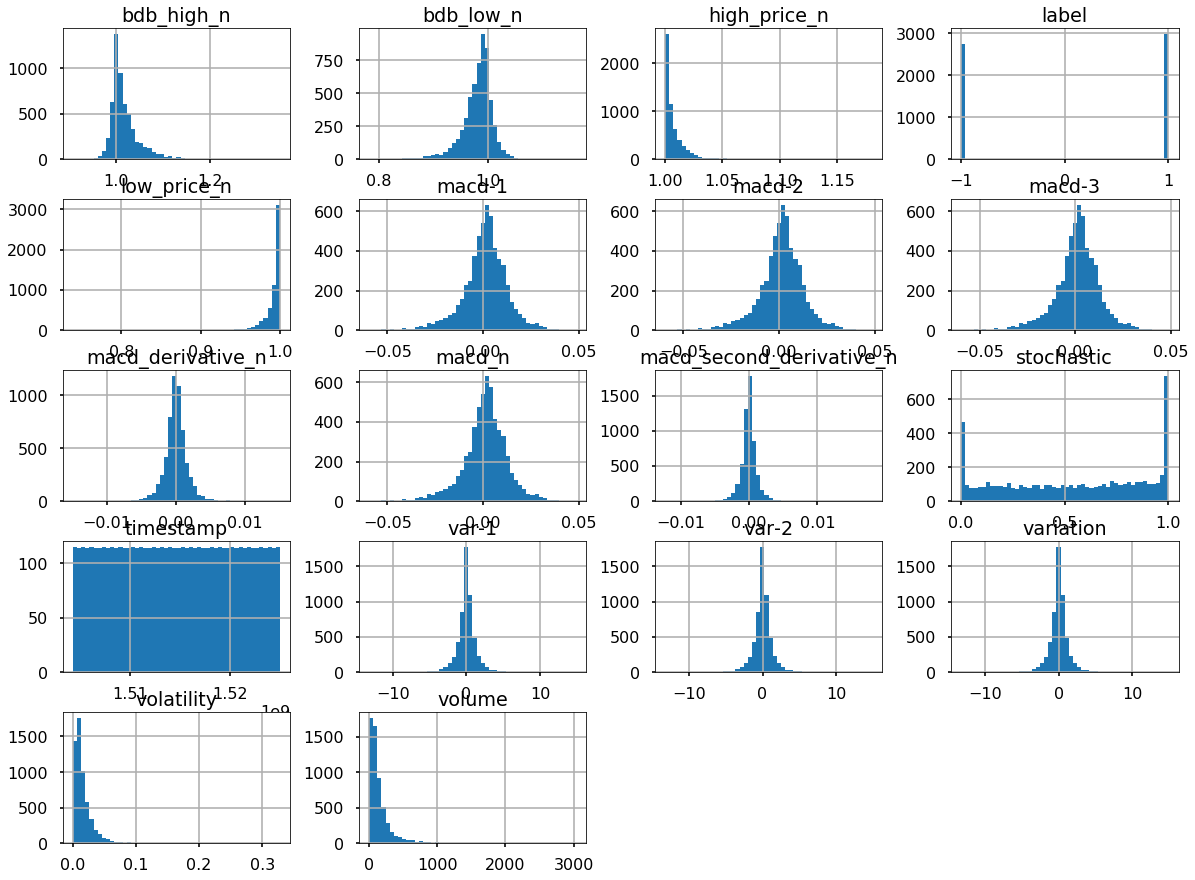

In [210]:
"""visualisation of our different parameters"""
df_primary.hist(bins=50, figsize=(20,15))
plt.show()

In [211]:
"""linear correlation with our label"""
corr_matrix  = df_primary.corr()
corr_matrix['label'].sort_values(ascending=False)

label                       1.000000
variation                   0.620300
macd-3                      0.056139
macd-2                      0.052871
macd-1                      0.047628
macd_n                      0.034900
var-2                       0.004596
volume                     -0.002935
bdb_low_n                  -0.010985
volatility                 -0.015235
bdb_high_n                 -0.017338
low_price_n                -0.022542
timestamp                  -0.022733
var-1                      -0.026672
high_price_n               -0.046411
stochastic                 -0.053470
macd_second_derivative_n   -0.062324
macd_derivative_n          -0.082051
Name: label, dtype: float64

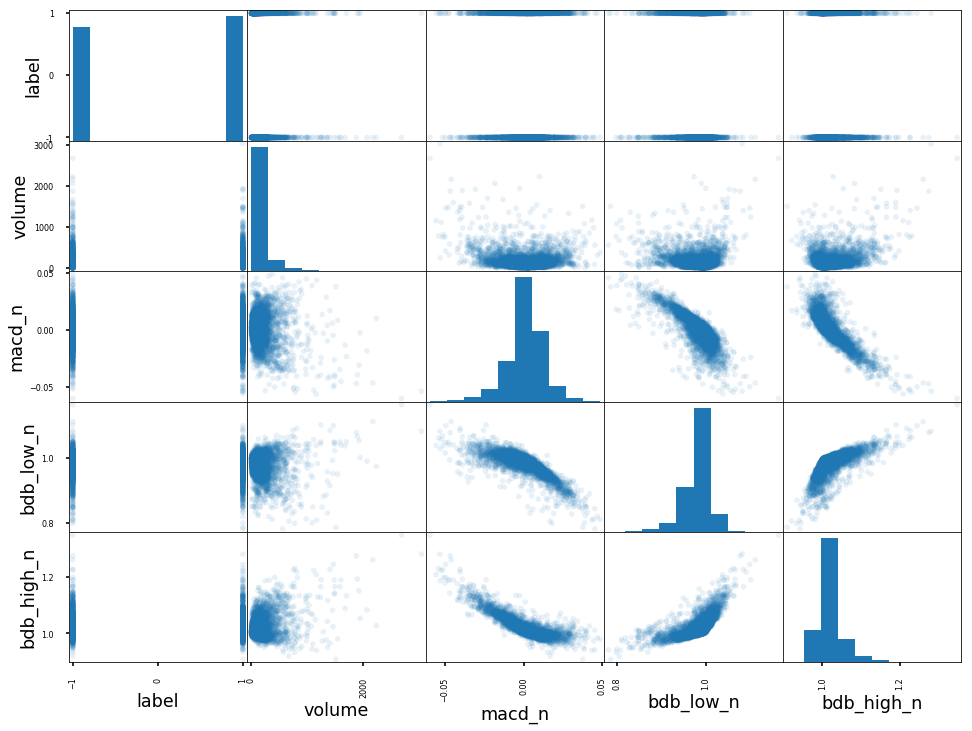

In [212]:
from pandas.plotting import scatter_matrix
"""correlation matrix"""
attributes = ['label', 'volume', 'macd_n', 'bdb_low_n','bdb_high_n']
scatter_matrix(df_primary[attributes], figsize=(16,12), alpha=0.1)
plt.show()

Interpretation des graphiques ci-dessus

When we have a threshold of 0.3 to trigger the 1 or -1 in the label we have absolutely no informations with all those graphics <br>
However, if we are moving the threshold to a big value like 5% we can see something interesting with the Bandes de Bollinger indicator <br>
Indeed, for a value like 5, we can see that our label is mostly a -1 when bdb_high_n is close to 1. And that our label is mostly a 1 when bdb_low_n is close to 1. <br>


Let's see more precisely what is allowing the bande de bollinger indicator <br>


1.027881391805147 83.90825121960162 125


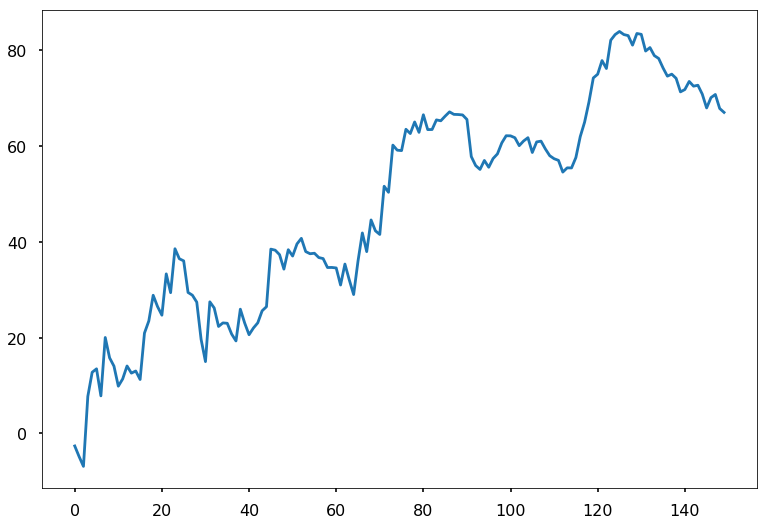

In [213]:
"""show bdb_low_n value for a sorted variation"""
ranking_variation = df_primary[['bdb_low_n', 'variation']].sort_values(by='variation', ascending=False).values.tolist()
"""show variation value for a sorted bdb_low_n value"""
ranking_bdb_low = df_primary[['variation', 'bdb_low_n']].sort_values(by='bdb_low_n', ascending=False).values.tolist()
"""return the sum of all variations for the top i bdb_low_n"""
total_sum = []
variation_sum = 0
for j in range(150):
    variation_sum += ranking_bdb_low[j][0] - 0.3
    total_sum.append(variation_sum)

max_index = total_sum.index(max(total_sum))
bdb_low_threshold = ranking_bdb_low[max_index][1]
print(bdb_low_threshold, max(total_sum), max_index)
L = [i for i in range(len(total_sum))]
plt.plot(L, total_sum)
plt.show()


0.9400401530983188 -6.912715427407589 4


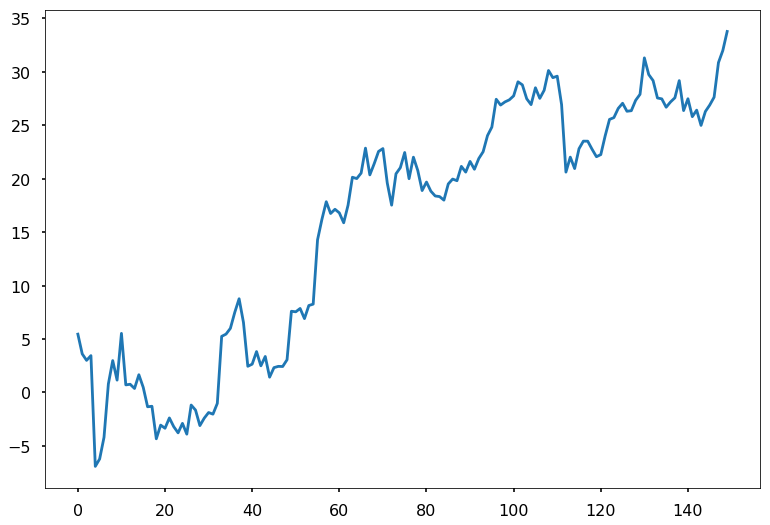

In [214]:
"""show bdb_high_n value for a sorted variation"""
ranking_variation = df_primary[['bdb_high_n', 'variation']].sort_values(by='variation', ascending=True).values.tolist()
"""show variation value for a sorted bdb_high_n value"""
ranking_bdb_high = df_primary[['variation', 'bdb_high_n']].sort_values(by='bdb_high_n', ascending=True).values.tolist()
"""return the sum of all variations for the top i bdb_high_n"""
#print(ranking_bdb_high)
total_sum = []
variation_sum = 0
for j in range(150):
    variation_sum += ranking_bdb_high[j][0] + 0.3
    total_sum.append(variation_sum)

min_index = total_sum.index(min(total_sum))
bdb_high_threshold = ranking_bdb_high[min_index][1]
print(bdb_high_threshold, min(total_sum), min_index)
L = [i for i in range(len(total_sum))]
plt.plot(L, total_sum)
plt.show()

In [215]:
"""Gain function"""
"""gradient = True return the last gain value not the list of the whole evolution"""
def strategy_based_results(decisions_list, market_prices_deltas, fee_rate=0.3, gradient = False):
    """
    Returns the list of successive gains if gradient = False.
    Prints other info like number of hold, buy, sell, free_cash, fee costs.
    """

    cash = True
    decisions_results = [100]
    decisions_results_evite = [100]
    fees_cost = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0
    if not gradient:
        
        for i in range(len(decisions_list)):

            if decisions_list[i] == 1 and cash:
                # Buy
                cash = False
                decisions_results.append(
                    decisions_results[-1]*(100 + market_prices_deltas[i] - fee_rate) / 100)
                fees_cost.append(
                    fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
                achat += 1

            elif decisions_list[i] == -1 and cash:
                # Wait
                decisions_results.append(decisions_results[-1])
                free_cash += 1

            elif decisions_list[i] == 0 and cash:
                # Wait
                decisions_results.append(decisions_results[-1])
                free_cash += 1

            elif decisions_list[i] == 0 and not cash:
                # Hold
                decisions_results.append(
                    decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
                hold += 1

            elif decisions_list[i] == -1 and not cash:
                # Sell
                cash = True
                decisions_results.append(
                    decisions_results[-1] * (100 - fee_rate) / 100)
                fees_cost.append(
                    fees_cost[-1] + decisions_results[-1] * fee_rate / 100)
                vente += 1

            elif decisions_list[i] == 1 and not cash:
                # Hold
                decisions_results.append(
                    decisions_results[-1] * (100 + market_prices_deltas[i]) / 100)
                hold += 1

            else:
                raise Exception
        transactions = achat + vente
        print("Gain total = ", str(round(decisions_results[-1] - 100,2)), "%.")
        print("Nombre de transactions = ", str(achat + vente))
        print("Argent dépensé en commissions = ", str(round(fees_cost[-1] - 100, 2)), "%.")
        print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
        print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
        return decisions_results

    elif gradient:
        decisions_results = 100

        for i in range(len(decisions_list)):
            if cash:
                if decisions_list[i] == 1:
                    # Buy
                    cash = False
                    decisions_results = decisions_results * (100 + market_prices_deltas[i] - fee_rate) / 100

            else:
                if decisions_list[i] in [0,1]:
                    # Hold
                    decisions_results = decisions_results * (100 + market_prices_deltas[i]) / 100

                else:
                    # Sell
                    cash = True
                    decisions_results = decisions_results * (100 - fee_rate) / 100
        
        return decisions_results
        

In [70]:
def buy_hold_results(market_prices_deltas):
    """
    Return the lists of real market prices evolution
    """
    market_var = [100]
    for delta in market_prices_deltas:
        market_var.append(market_var[-1] * (100 + delta) / 100)
    #print("Variation réelle = ", str(round(market_var[-1] - 100,2)), "%.")
    return market_var

In [71]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file

def plot_strategy_with_labels(labels, decisions, prices, decisions_results, notebook=False, other_lines=[]):
    if notebook:
        output_notebook()
    else:
        output_file("plot.html")
    # the good and bad choices are plotted but not the average
    x_time = [i for i in range(len(prices))]
    x_sell_sell = []
    x_buy_sell = []
    x_sell_buy = []
    x_buy_buy = []
    y_sell_sell = []
    y_buy_sell = []
    y_sell_buy = []
    y_buy_buy = []
    for i in range(len(labels)):
        if labels[i] == -1 and decisions[i] == -1: # sell/sell (label/prediction)
            x_sell_sell.append(i)
            y_sell_sell.append(prices[i])
        elif labels[i] == -1 and decisions[i] == 1: # sell/buy
            x_sell_buy.append(i)
            y_sell_buy.append(prices[i])
        elif labels[i] == 1 and decisions[i] == -1: # buy/sell
            x_buy_sell.append(i)
            y_buy_sell.append(prices[i])
        elif labels[i] == 1 and decisions[i] == 1: # buy/buy
            x_buy_buy.append(i)
            y_buy_buy.append(prices[i])
            
    p = figure(plot_width=800, plot_height=600, title='Decisions, labels and price',
               x_axis_label='Time', y_axis_label='Price')

    p.line(x_time, prices, legend='Price', line_alpha=0.2)
    p.line(x_time, decisions_results, legend='Gain', line_alpha=0.6)
    for line in other_lines:
        p.line(x_time, line['data'], legend=line['legend'], line_alpha=0.2)

    p.inverted_triangle(x_sell_sell, y_sell_sell, legend='should sell -> sell', size=8,
                        line_color="mediumseagreen", fill_color="mediumseagreen", fill_alpha=0.5)
    p.inverted_triangle(x_sell_buy, y_sell_buy, legend='should sell -> buy',
                        size=8, line_color="crimson", fill_color="crimson", fill_alpha=0.5)
    p.triangle(x_buy_sell, y_buy_sell, size=8, legend='should buy -> sell',
               line_color="crimson", fill_color="crimson", fill_alpha=0.5)
    p.triangle(x_buy_buy, y_buy_buy, size=8, legend='should buy -> buy',
               line_color="mediumseagreen", fill_color="mediumseagreen", fill_alpha=0.5)
    show(p)

In [216]:
"""Creation Testing, training set"""
X = np.array(df_training.drop('label',1))
y = np.array(df_training['label'])
X_train, X_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(X)*0.8)], y[int(len(X)*0.8):]


Gain total =  -82.62 %.
Nombre de transactions =  572
Argent dépensé en commissions =  72.58 %.
Nombre de chandeliers sans cash engagé =  331
Nombre de chandeliers sur lesquels on a juste hold =  242


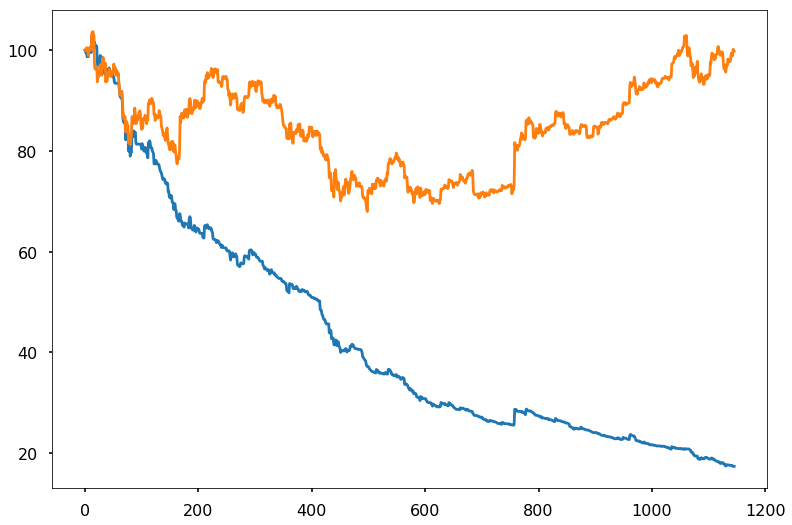

Loading BokehJS ...

"#logreg\nlogreg = LogisticRegression()\nlogreg.fit(X_train, y_train)\nY_pred = logreg.predict(X_test)\nacc_log = round(logreg.score(X_train, y_train) * 100, 2)\n\n\n# Support Vector Machines\nsvc = SVC()\nsvc.fit(X_train, y_train)\nY_pred = svc.predict(X_test)\nacc_svc = round(svc.score(X_train, y_train) * 100, 2)\n\n\n#kNN\nknn = KNeighborsClassifier(n_neighbors = 3)\nknn.fit(X_train, y_train)\nY_pred = knn.predict(X_test)\nacc_knn = round(knn.score(X_train, y_train) * 100, 2)\n\n\n# Gaussian Naive Bayes\ngaussian = GaussianNB()\ngaussian.fit(X_train, y_train)\nY_pred = gaussian.predict(X_test)\nacc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)\n\n# Perceptron\nperceptron = Perceptron()\nperceptron.fit(X_train, y_train)\nY_pred = perceptron.predict(X_test)\nacc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)\n\n\n# Linear SVC\nlinear_svc = LinearSVC()\nlinear_svc.fit(X_train, y_train)\nY_pred = linear_svc.predict(X_test)\nacc_linear_svc = round(linear_sv

In [217]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#useful to create the market_prices list
dh = df.iloc[4577:,:]

#classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test).tolist()
#score
score = clf.score(X_train, y_train)

market_prices = dh['variation'].values.tolist()

decisions_results = strategy_based_results(predictions, market_prices, fee_rate = 0.3)
market_var = buy_hold_results(market_prices)
L = [i for i in range(len(decisions_results))]

#affichage de nos résultats
plt.plot(L, decisions_results)
plt.plot(L, market_var)
plt.show()

#bokeh graph
label = dh['label'].values.tolist()
plot_strategy_with_labels(label, predictions, market_var, decisions_results, notebook=True)

"""#logreg
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)


# Support Vector Machines
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)


#kNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)


# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)


# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)


# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)


# Decision Tree
decision_tree = LogisticRegression()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)


# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)


models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
print(models.sort_values(by='Score', ascending=False))

#logreg
acc_log_test = round(logreg.score(X_test, y_test) * 100, 2)


# Support Vector Machines
acc_svc_test = round(svc.score(X_test, y_test) * 100, 2)


#kNN
acc_knn_test = round(knn.score(X_test, y_test) * 100, 2)


# Gaussian Naive Bayes
acc_gaussian_test = round(gaussian.score(X_test, y_test) * 100, 2)

# Perceptron
acc_perceptron_test = round(perceptron.score(X_test, y_test) * 100, 2)


# Linear SVC
acc_linear_svc_test = round(linear_svc.score(X_test, y_test) * 100, 2)


# Stochastic Gradient Descent
acc_sgd_test = round(sgd.score(X_test, y_test) * 100, 2)


# Decision Tree
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)


# Random Forest
acc_random_forest_test = round(random_forest.score(X_test, y_test) * 100, 2)


test_models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc_test, acc_knn_test, acc_log_test, 
              acc_random_forest_test, acc_gaussian_test, acc_perceptron_test, 
              acc_sgd_test, acc_linear_svc_test, acc_decision_tree_test]})
test_models.sort_values(by='Score', ascending=False)"""